**1. Data Loading and Preprocessing**

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Load datasets
customers_path = '/content/Customers.csv'  # Replace with actual paths if needed
transactions_path = '/content/Transactions.csv'

customers = pd.read_csv(customers_path)
transactions = pd.read_csv(transactions_path)

# Verify data loading
print(customers.head())
print(products.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

**2. Feature Engineering**

In [9]:
# Convert 'SignupDate' to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'], errors='coerce')

# Merge transaction and product details
merged_df = pd.merge(transactions, products, on='ProductID', how='left')

# Merge with customer details to create a consolidated DataFrame
merged_df = pd.merge(merged_df, customers, on='CustomerID', how='left')

# Aggregate customer-level features
customer_features = merged_df.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    NumTransactions=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean'),
    UniqueProducts=('ProductID', 'nunique')
).reset_index()

# Add 'SignupDate' and 'Region' from the original 'customers' DataFrame
customer_features = pd.merge(customer_features, customers[['CustomerID', 'SignupDate', 'Region']], on='CustomerID', how='left')

# Calculate 'DaysSinceSignup'
customer_features['DaysSinceSignup'] = (datetime.now() - customer_features['SignupDate']).dt.days

# Drop the 'SignupDate' column as it's no longer needed
customer_features = customer_features.drop(columns=['SignupDate'])

# One-hot encode the 'Region' column
customer_features = pd.get_dummies(customer_features, columns=['Region'], prefix='Region', dummy_na=True)

# Verify the resulting DataFrame
print(customer_features.head())


  CustomerID  TotalSpending  NumTransactions  AvgTransactionValue  \
0      C0001        3354.52                5              670.904   
1      C0002        1862.74                4              465.685   
2      C0003        2725.38                4              681.345   
3      C0004        5354.88                8              669.360   
4      C0005        2034.24                3              678.080   

   UniqueProducts  DaysSinceSignup  Region_Asia  Region_Europe  \
0               5              932        False          False   
1               4             1079         True          False   
2               4              326        False          False   
3               8              841        False          False   
4               3              896         True          False   

   Region_North America  Region_South America  Region_nan  
0                 False                  True       False  
1                 False                 False       False  
2       

**3. Enhanced Feature Engineering**

In [10]:
# Convert 'TransactionDate' to datetime in the merged DataFrame
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'], errors='coerce')

# Add 'DaysSinceLastPurchase' feature
last_purchase = merged_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_purchase['DaysSinceLastPurchase'] = (datetime.now() - last_purchase['TransactionDate']).dt.days
customer_features = pd.merge(customer_features, last_purchase[['CustomerID', 'DaysSinceLastPurchase']], on='CustomerID', how='left')

# Handle NaN in 'DaysSinceLastPurchase' (impute with 0)
customer_features['DaysSinceLastPurchase'] = customer_features['DaysSinceLastPurchase'].fillna(0)

# Calculate purchase frequency per category
category_freq = merged_df.groupby(['CustomerID', 'Category'])['TransactionID'].count().reset_index()
category_freq = category_freq.pivot(index='CustomerID', columns='Category', values='TransactionID').fillna(0)
category_freq.columns = ['CategoryFreq_' + str(col) for col in category_freq.columns]
customer_features = customer_features.merge(category_freq, left_on='CustomerID', right_index=True, how='left')

# Verify the updated DataFrame
print(customer_features.head())


  CustomerID  TotalSpending  NumTransactions  AvgTransactionValue  \
0      C0001        3354.52                5              670.904   
1      C0002        1862.74                4              465.685   
2      C0003        2725.38                4              681.345   
3      C0004        5354.88                8              669.360   
4      C0005        2034.24                3              678.080   

   UniqueProducts  DaysSinceSignup  Region_Asia  Region_Europe  \
0               5              932        False          False   
1               4             1079         True          False   
2               4              326        False          False   
3               8              841        False          False   
4               3              896         True          False   

   Region_North America  Region_South America  Region_nan  \
0                 False                  True       False   
1                 False                 False       False   
2    

**4. Scaling Numerical Features**


In [11]:
# Identify numerical columns
numerical_cols = customer_features.select_dtypes(include=np.number).columns.tolist()

# Standardize numerical columns
scaler = StandardScaler()
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

# Verify scaled features
print(customer_features.head())


  CustomerID  TotalSpending  NumTransactions  AvgTransactionValue  \
0      C0001      -0.061701        -0.011458            -0.070263   
1      C0002      -0.877744        -0.467494            -0.934933   
2      C0003      -0.405857        -0.467494            -0.026271   
3      C0004       1.032547         1.356650            -0.076769   
4      C0005      -0.783929        -0.923530            -0.040028   

   UniqueProducts  DaysSinceSignup  Region_Asia  Region_Europe  \
0        0.050047         1.148752        False          False   
1       -0.424204         1.600431         True          False   
2       -0.424204        -0.713270        False          False   
3        1.472798         0.869141        False          False   
4       -0.898455         1.038137         True          False   

   Region_North America  Region_South America  Region_nan  \
0                 False                  True       False   
1                 False                 False       False   
2    

**5. Clustering**

Davies-Bouldin Index: 1.7445846524334538


<ipython-input-14-1eb6177f4b06>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=customer_features, palette='viridis')


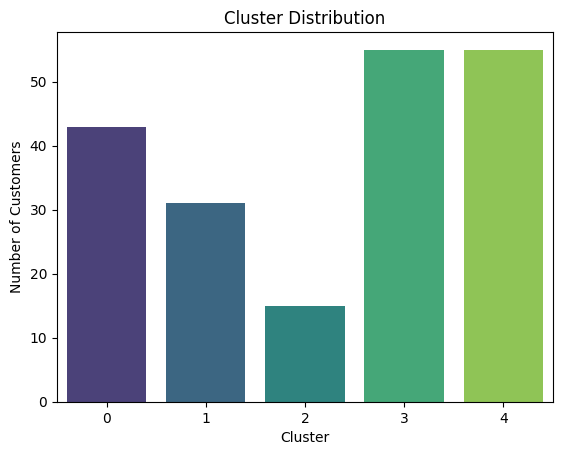

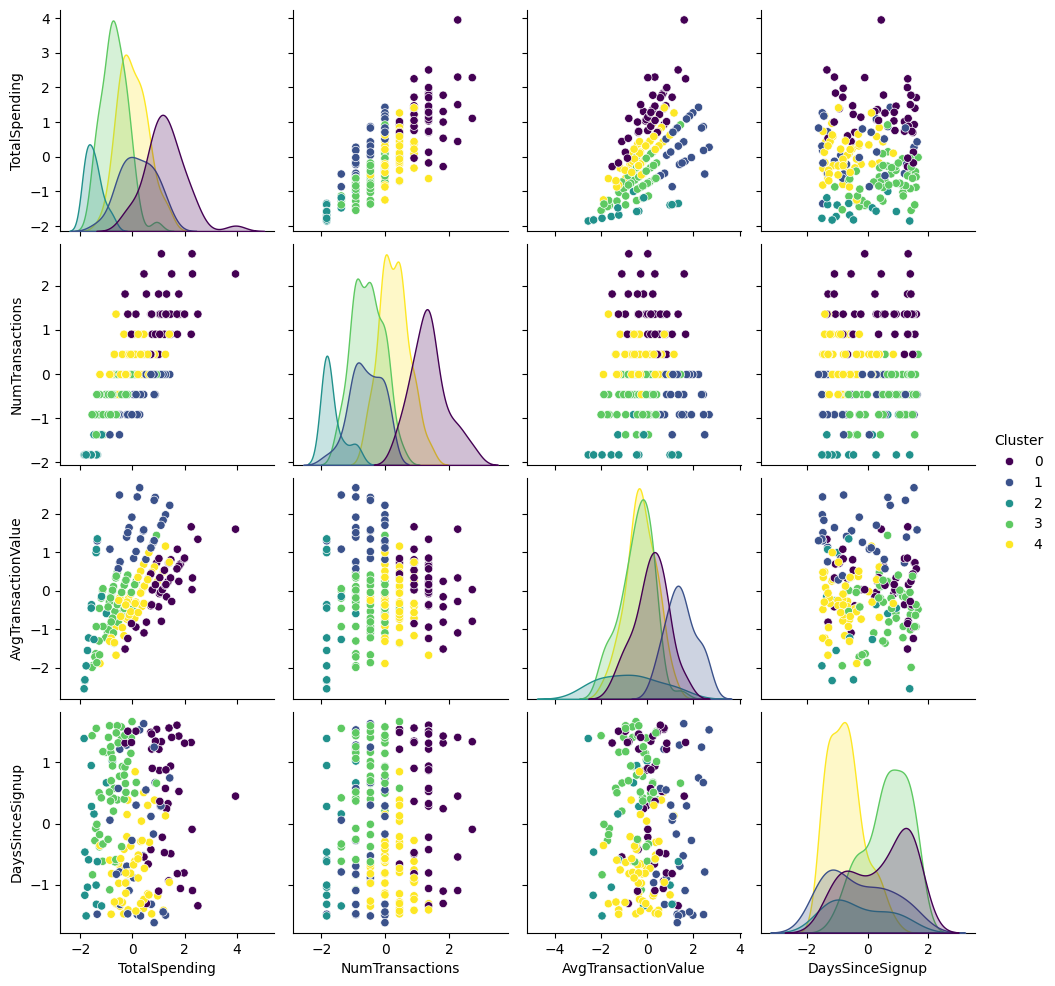

In [14]:
# Apply K-Means clustering
num_clusters = 5  # Example: Choose 5 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features[numerical_cols])

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(customer_features[numerical_cols], customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# --- Visualization ---
# Visualize cluster distribution
sns.countplot(x='Cluster', data=customer_features, palette='viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Pairplot for a subset of features
subset_cols = ['TotalSpending', 'NumTransactions', 'AvgTransactionValue', 'DaysSinceSignup']
sns.pairplot(customer_features, vars=subset_cols, hue='Cluster', palette='viridis')
plt.show()

**6. Export Results**

In [13]:
# Save the clustering results to a CSV file
customer_features.to_csv("ClusteringResults.csv", index=False)
print("Clustering results saved to 'ClusteringResults.csv'!")


Clustering results saved to 'ClusteringResults.csv'!
